=== Анализ данных Google Analytics ===

1. Загрузка данных...
✅ Данные успешно загружены
Размер sessions: (1860042, 18)
Размер hits: (15726470, 11)

Первые строки sessions:
                                  session_id              client_id  \
0  9055434745589932991.1637753792.1637753792  2108382700.1637753791   
1   905544597018549464.1636867290.1636867290   210838531.1636867288   
2  9055446045651783499.1640648526.1640648526  2108385331.1640648523   

   visit_date visit_time  visit_number            utm_source utm_medium  \
0  2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1  2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2  2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   

           utm_campaign         utm_adcontent           utm_keyword  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
1  FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO  IGUCNvHlhfHpROGclCit   
2  LEoPHuyFvzoNfnzGgfcd  vCI

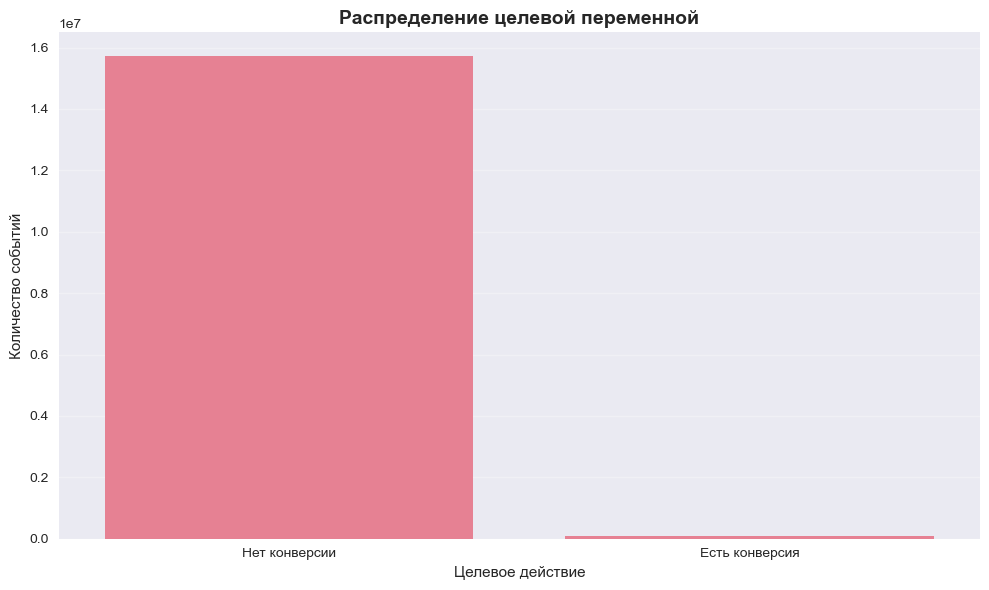

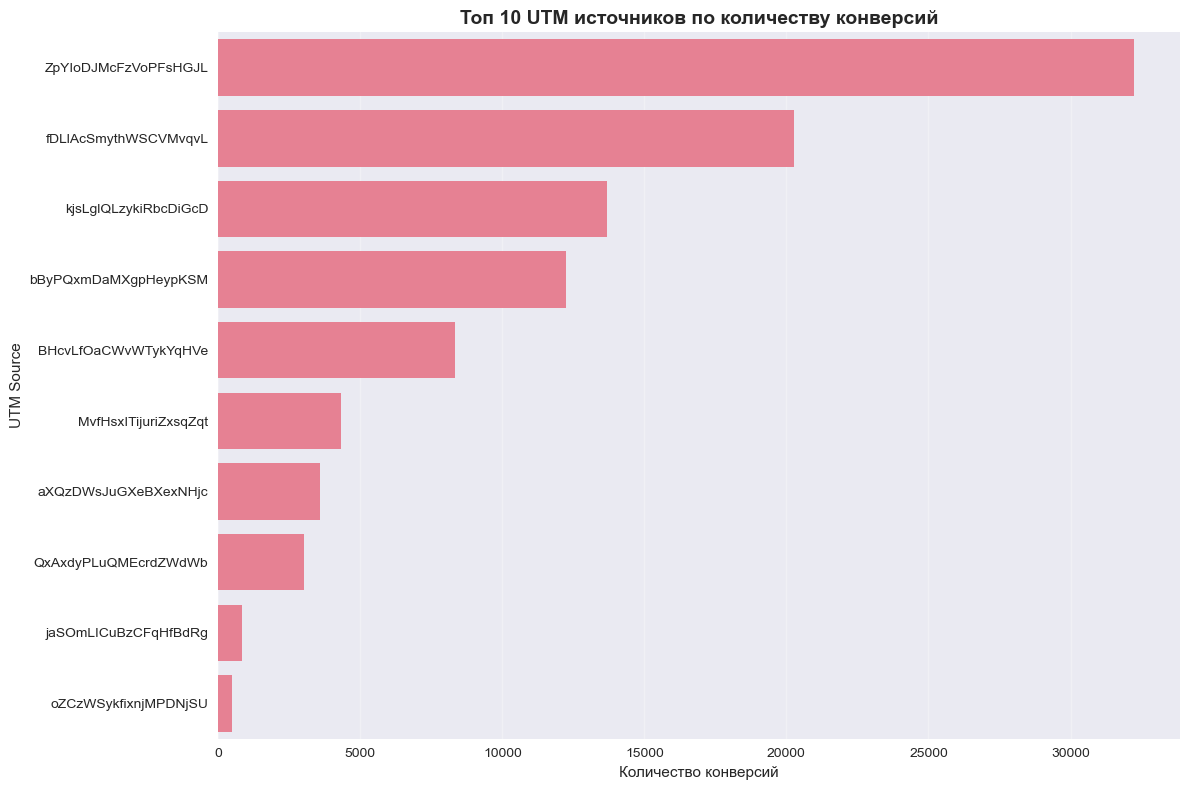

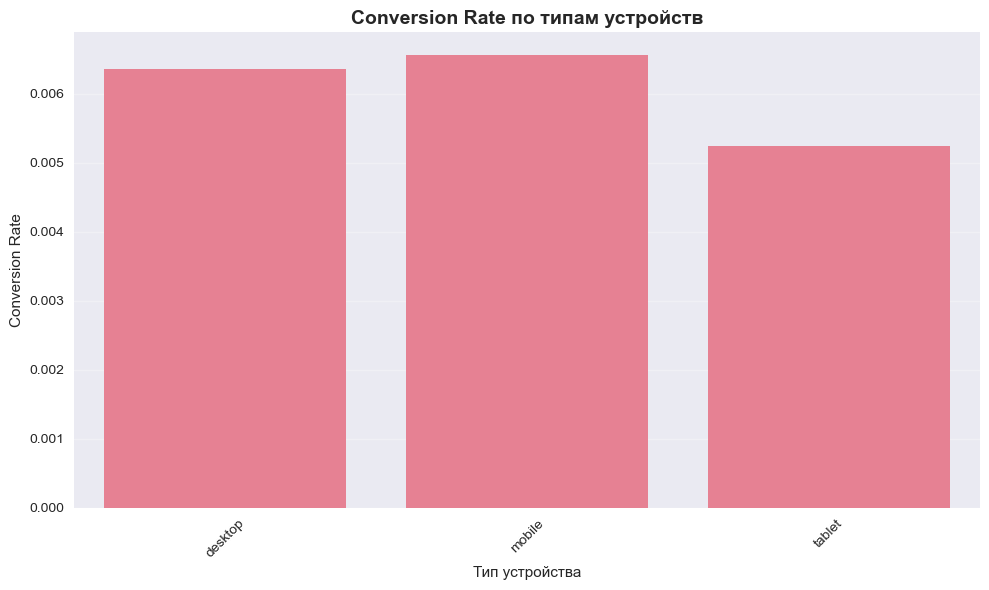

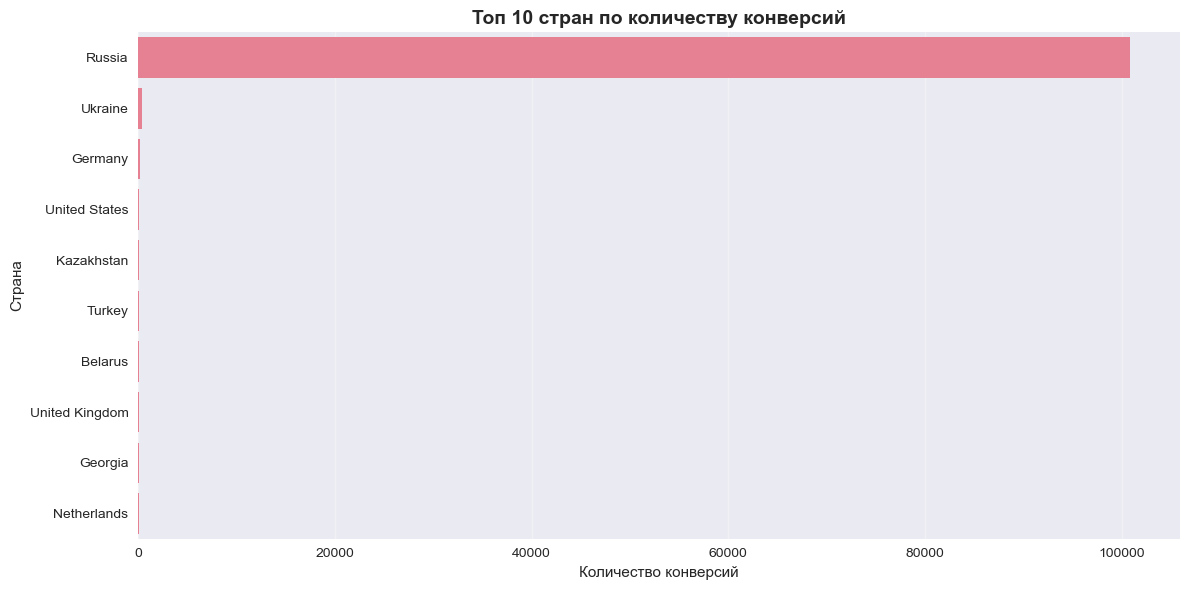

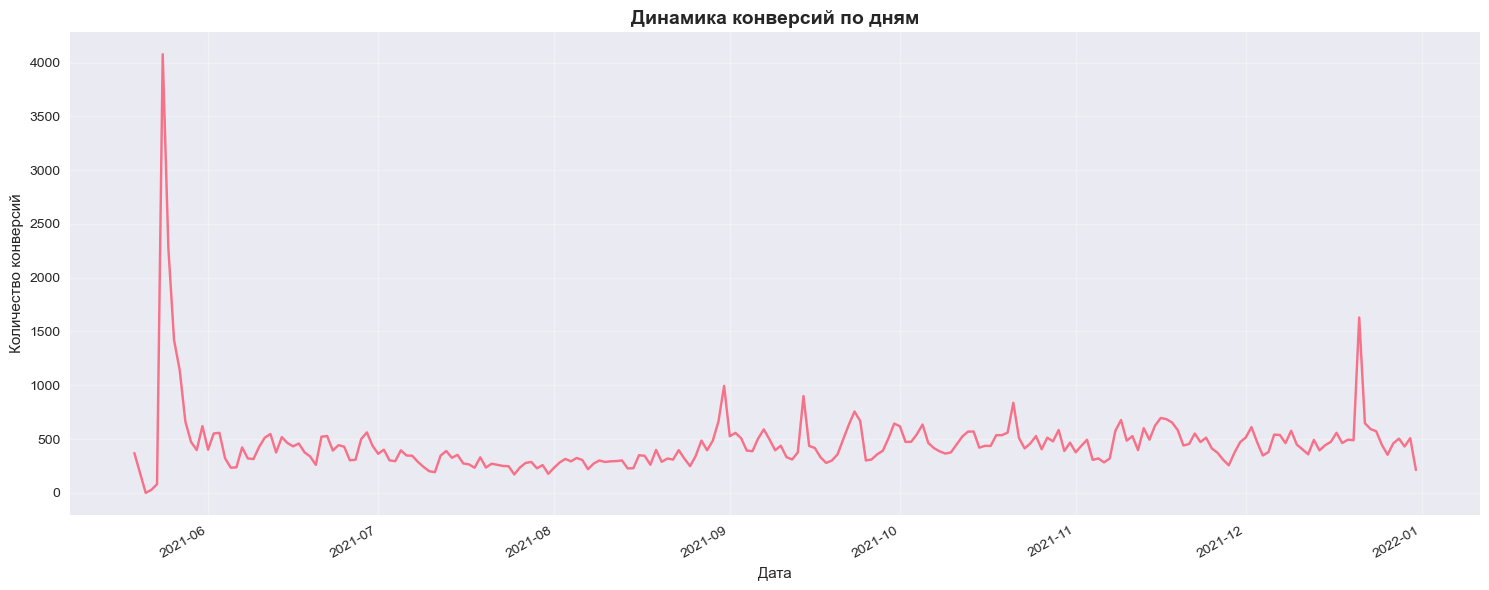


💾 Сохранение данных...
✅ Данные сохранены в ga_data_processed.csv

АНАЛИЗ ЗАВЕРШЕН!

📊 ФИНАЛЬНАЯ СВОДКА:
• Общий размер данных: (15812995, 29)
• Конверсий: 102,842 (0.65%)
• Уникальных сессий: 1,860,042
• Уникальных UTM источников: 293
• Файлы сохранены: ga_data_processed.csv
• Графики сохранены в папке: plots/


In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from datetime import datetime

# Настройки отображения
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
sns.set_palette("husl")

print("=== Анализ данных Google Analytics ===\n")

# 1. Загрузка данных
print("1. Загрузка данных...")

try:
    sessions = pd.read_pickle('ga_sessions.pkl')
    hits = pd.read_pickle('ga_hits.pkl')
    print("✅ Данные успешно загружены")
except FileNotFoundError:
    print("❌ Файлы данных не найдены")
    print("Убедитесь, что файлы ga_sessions.pkl и ga_hits.pkl находятся в текущей директории")
    raise

print(f"Размер sessions: {sessions.shape}")
print(f"Размер hits: {hits.shape}")

# Предварительный просмотр данных
print("\nПервые строки sessions:")
print(sessions.head(3))
print("\nПервые строки hits:")
print(hits.head(3))

# 2. Объединение sessions + hits
print("\n2. Объединение данных...")

# Проверка уникальности session_id
print(f"Уникальных session_id в sessions: {sessions['session_id'].nunique()}")
print(f"Уникальных session_id в hits: {hits['session_id'].nunique()}")

# Объединение данных
data = sessions.merge(hits, on='session_id', how='left')
print(f"✅ Размер объединенного датасета: {data.shape}")

# 3. Анализ структуры данных
print("\n3. Анализ структуры данных:")

# Основная информация
print("\nОсновная информация о данных:")
print(f"Количество строк: {len(data):,}")
print(f"Количество столбцов: {len(data.columns)}")
print(f"Уникальных сессий: {data['session_id'].nunique():,}")
print(f"Уникальных клиентов: {data['client_id'].nunique():,}")

# Пропущенные значения
print("\n🔍 Анализ пропущенных значений:")
missing_data = data.isna().sum()
missing_percent = (missing_data / len(data)) * 100

missing_info = pd.DataFrame({
    'Пропущено': missing_data,
    'Процент': missing_percent
}).sort_values('Пропущено', ascending=False)

print(missing_info[missing_info['Пропущено'] > 0].head(10))

# Типы данных
print("\n📊 Типы данных:")
print(data.dtypes.value_counts())

# 4. Анализ целевых действий
print("\n4. Анализ целевых действий:")

# Определяем целевые действия
target_actions = [
    'sub_car_claim_click', 'sub_car_claim_submit_click', 
    'sub_open_dialog_click', 'sub_custom_question_submit_click', 
    'sub_call_number_click', 'sub_callback_submit_click', 
    'sub_submit_success', 'sub_car_request_submit_click'
]

print("Целевые действия:")
for action in target_actions:
    count = len(data[data['event_action'] == action])
    print(f"  {action}: {count}")

# Создаем целевую переменную
data['target'] = data['event_action'].isin(target_actions).astype(int)

# Распределение конверсий
conversion_stats = data['target'].value_counts()
conversion_rate = data['target'].mean()

print(f"\n📈 Статистика конверсий:")
print(f"Конверсий (1): {conversion_stats[1]:,}")
print(f"Не конверсий (0): {conversion_stats[0]:,}")
print(f"Conversion Rate: {conversion_rate:.4f} ({conversion_rate*100:.2f}%)")

# Анализ по UTM источникам
print("\n🎯 Top converting UTM sources:")
utm_conversions = data.groupby('utm_source')['target'].agg(['sum', 'count', 'mean']).reset_index()
utm_conversions = utm_conversions.rename(columns={
    'sum': 'conversions', 
    'count': 'sessions', 
    'mean': 'conversion_rate'
})
top_utm = utm_conversions.nlargest(10, 'conversions')
print(top_utm[['utm_source', 'conversions', 'sessions', 'conversion_rate']])

# Device/category анализ
print("\n📱 Конверсии по типам устройств:")
device_conversions = data.groupby('device_category')['target'].agg(['sum', 'count', 'mean']).reset_index()
device_conversions = device_conversions.rename(columns={
    'sum': 'conversions', 
    'count': 'sessions', 
    'mean': 'conversion_rate'
})
print(device_conversions)

# 5. Визуализации
print("\n5. Создание визуализаций...")

# Создаем папку для графиков
os.makedirs('plots', exist_ok=True)

# Распределение целевой переменной
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='target')
plt.title('Распределение целевой переменной', fontsize=14, fontweight='bold')
plt.xlabel('Целевое действие')
plt.ylabel('Количество событий')
plt.xticks([0, 1], ['Нет конверсии', 'Есть конверсия'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Топ UTM-источники по конверсиям
plt.figure(figsize=(12, 8))
top_utm_plot = top_utm.head(10)
sns.barplot(data=top_utm_plot, x='conversions', y='utm_source')
plt.title('Топ 10 UTM источников по количеству конверсий', fontsize=14, fontweight='bold')
plt.xlabel('Количество конверсий')
plt.ylabel('UTM Source')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/top_utm_sources.png', dpi=300, bbox_inches='tight')
plt.show()

# Конверсии по типам устройств
plt.figure(figsize=(10, 6))
sns.barplot(data=device_conversions, x='device_category', y='conversion_rate')
plt.title('Conversion Rate по типам устройств', fontsize=14, fontweight='bold')
plt.xlabel('Тип устройства')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/device_conversions.png', dpi=300, bbox_inches='tight')
plt.show()

# Гео-распределение
plt.figure(figsize=(12, 6))
geo_conversions = data.groupby('geo_country')['target'].sum().nlargest(10)
sns.barplot(x=geo_conversions.values, y=geo_conversions.index)
plt.title('Топ 10 стран по количеству конверсий', fontsize=14, fontweight='bold')
plt.xlabel('Количество конверсий')
plt.ylabel('Страна')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/geo_conversions.png', dpi=300, bbox_inches='tight')
plt.show()

# Временное распределение (если есть дата)
if 'visit_date' in data.columns:
    try:
        data['visit_date'] = pd.to_datetime(data['visit_date'])
        daily_conversions = data.groupby('visit_date')['target'].sum()
        
        plt.figure(figsize=(15, 6))
        daily_conversions.plot()
        plt.title('Динамика конверсий по дням', fontsize=14, fontweight='bold')
        plt.xlabel('Дата')
        plt.ylabel('Количество конверсий')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('plots/daily_conversions.png', dpi=300, bbox_inches='tight')
        plt.show()
    except:
        print("⚠️ Невозможно построить временной график")

# Сохранение обработанных данных
print("\n💾 Сохранение данных...")
data.to_csv('ga_data_processed.csv', index=False)
print("✅ Данные сохранены в ga_data_processed.csv")

print("\n" + "="*50)
print("АНАЛИЗ ЗАВЕРШЕН!")
print("="*50)

# Финальная сводка
print(f"\n📊 ФИНАЛЬНАЯ СВОДКА:")
print(f"• Общий размер данных: {data.shape}")
print(f"• Конверсий: {conversion_stats[1]:,} ({conversion_rate*100:.2f}%)")
print(f"• Уникальных сессий: {data['session_id'].nunique():,}")
print(f"• Уникальных UTM источников: {data['utm_source'].nunique()}")
print(f"• Файлы сохранены: ga_data_processed.csv")
print(f"• Графики сохранены в папке: plots/")